## Prepare
##### Terms

- $J_i$: job $i$
- $P_l^i$: operation $l$ of job $i$
- $G_g^i$: operation group $g$ of job $i$
- $M_k$: machine $k$
- $MG_g^i$: set of machines indices that $G_g^i$ might use

##### Decision Variables

- $X_{ilj}^{k}$ := $P_l^i$ (operation $l$ of job $i$) is on the order-position $j$ on $M_k$
- $h_j^k$ := starting time of order-position $j$ on $M_k$
- $s_j^k$ := time elapsed between order-position $j$ and $j+1$ on $M_k$
- $s_0^k$ := idle time from start to first order-position on $M_k$
- $n(k)$ := max number of order-positions $M_k$ can possibly process
- $N(k)$ := job & operation pair $(i, l)$, or $(J_i, P_l^i)$, that can possibly use $M_k$
- $TX_j^k$ := process time of the $j$-th order-position task on $M_k$

##### Known Variables

- $t_{il}^{k}$ := time needed for $P_l^i$ (operation $l$ of job $i$) on using $M_k$
- $c_{il}^{S}$ := total numbers of time $P_l^i$ will use any machine $M_k \in S$ 

## Objective

\begin{align*}
\min \quad h ^ *
\end{align*}

## Constraint

##### Constraint Set 1: each job & operation is completed by its required machine(s)

\begin{align*}
&   \quad \sum_{k \in S} \sum_{j=1}^{n(k)} X_{ilj}^k = c_{il}^{S}, \ \forall (i, l)\\
\end{align*}

##### Constraint Set 2: each machine's each order-position can have at most 1 job a time

\begin{align*}
&   \quad \sum_{(i, l) \in N(k)} X_{ilj}^k \leq 1, \ \forall j \in [n(k)], \ \forall k \in M\\
\end{align*}

##### Constraint Set 3: define time variables (for ordering constraints) 

\begin{align*}
&   \quad TX_j^k = \sum_{(i, l) \in N(k)} t_{il}^k X_{ilj}^k, \ \forall j \in [n(k)], \ \forall k \in M\\
\end{align*}

\begin{align*}
&   \quad h_1^k = s_0^k, \ \forall k \in M\\
&   \quad h_j^k = \sum_{q = 1}^{j-1} TX_{q}^k + \sum_{q = 0}^{j-1} S_{q}^k, \ \forall j \in 2 \cdots n(k), \ \forall k \in M\\
\end{align*}

##### Constraint Set 4: for each job, each group must be complete in the given group order

\begin{align*}
&   \quad h_{j'}^a + t_{il'}^a X_{il'j'}^a \leq h_{j''}^b + M(1-X_{il'j'}^a) + M(1-X_{il''j''}^b) \\
&   \quad \quad \quad \forall a \in MG_g^i, \forall b \in MG_{g+1}^i, \forall P_{l'}^i \in G_g^i, \forall P_{l''}^i \in G_{g+1}^i, 
\forall j' \in [n(a)], \forall j'' \in [n(b)], \forall G_g^i \in i, \forall i
\end{align*}

##### Constraint Set 5: for each job, within each group, order doesn't matter, but must only take one machine per time

\begin{align*}
&   \quad h_{j'}^a + t_{il'}^a X_{il'j'}^a \leq h_{j''}^b + M(1-X_{il'j'}^a) + M(1-X_{il''j''}^b) + \delta M \\
&   \quad h_{j''}^a + t_{il''}^a X_{il''j''}^a \leq h_{j'}^b + M(1-X_{il'j'}^a) + M(1-X_{il''j''}^b) + (1 - \delta) M \\
&   \quad \quad \quad 
\forall (a, b) \in MG_g^i, \forall (P_{l'}^i, P_{l''}^i) \in G_g^i, 
\forall j' \in [n(a)], \forall j'' \in [n(b)], \forall G_g^i \in i, \forall i
\end{align*}

##### Constraint Set 6: define make span

\begin{align*}
&   \quad h ^ * \geq h_{n(k)}^k + TX_{n(k)}^k, \ \forall k \in M\\
\end{align*}

In [64]:
# Define your sets based on the problem
# Replace these with actual numbers
II = 3 # Number of jobs
LL = Dict(1 => 5, 2 => 6, 3 => 4)  # Number of operations for each job
GG = Dict(1 => 4, 2 => 5, 3 => 3)  # Number of groups for each job
MM = 6 # Number of machines
# from all (i, g) job-i group-g to machines that this group might use
MG = Dict(
    (1, 1) => [1], (1, 2) => [2, 3], (1, 3) => [4], (1, 4) => [5, 6],
    (2, 1) => [1], (2, 2) => [2, 3], (2, 3) => [4], (2, 4) => [5, 6], (2, 5) => [5, 6],
    (3, 1) => [1, 6], (3, 2) => [6], (3, 3) => [5, 6]
) 
# max number of order-positions machine-k can possibly process
nk = Dict(1 => 3, 2 => 2, 3 => 2, 4 => 1, 5 => 5, 6 => 7)
# all (i, l) job-i operation-l pairs that can possibly use machine-k
Nk = Dict(
    1 => [(1, 1), (2, 1), (3, 1)], 
    2 => [(1, 2), (2, 2)], 
    3 => [(1, 3), (2, 3)],
    4 => [(2, 4)], 
    5 => [(1, 4), (1, 5), (2, 5), (2, 6), (3, 4)], 
    6 => [(1, 4), (1, 5), (2, 5), (2, 6), (3, 4), (3, 2), (3, 3)]
)
# GroupOps: from each (i, g) to the operation indices (l) 
GroupOps = Dict(
    (1, 1) => [1], (1, 2) => [2, 3], (1, 3) => [4], (1, 4) => [5],
    (2, 1) => [1], (2, 2) => [2, 3], (2, 3) => [4], (2, 4) => [5], (2, 5) => [6],
    (3, 1) => [1, 2], (3, 2) => [3], (3, 3) => [4]
)
# time needed for job-i operation-l to use machine-k
TILK = Dict(
    (1, 1, 1) => 30, 
    (1, 2, 2) => 30,
    (1, 3, 3) => 60,
    (1, 4, 5) => 20,
    (1, 4, 6) => 10,
    (1, 5, 5) => 5,
    (1, 5, 6) => 5,
    (2, 1, 1) => 30, 
    (2, 2, 2) => 30,
    (2, 3, 3) => 60,
    (2, 4, 4) => 20,
    (2, 5, 5) => 40,
    (2, 5, 6) => 20,
    (2, 6, 5) => 5,
    (2, 6, 6) => 5,
    (3, 1, 1) => 30, 
    (3, 2, 6) => 30,
    (3, 3, 6) => 60,
    (3, 4, 5) => 5,
    (3, 4, 6) => 5,
)
# all job-i operation-l pairs
JO = [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4)];
# JobLMachine: from (i, l) job-i operation-l pairs to the machines that can be potentially used
JobLMachine = Dict(
    (1, 1) => [1],
    (1, 2) => [2],
    (1, 3) => [3], 
    (1, 4) => [5, 6], 
    (1, 5) => [5, 6], 
    (2, 1) => [1],
    (2, 2) => [2],
    (2, 3) => [3], 
    (2, 4) => [4], 
    (2, 5) => [5, 6], 
    (2, 6) => [5, 6], 
    (3, 1) => [1],
    (3, 2) => [6],
    (3, 3) => [6], 
    (3, 4) => [5, 6]
)
# group count for each job
GCJ = Dict(1 => 4, 2 => 5, 3 => 3)
;

In [68]:
# using Gurobi, JuMP
# Initialize the model with the Gurobi solver
model = Model(Gurobi.Optimizer)
validx = [ (i, l, j, k) for (i, l) in JO for k in JobLMachine[(i, l)] for j in 1:nk[k] ]
@variable(model, x[validx], Bin)
@variable(model, h[[ (j, k) for k in 1:MM for j in 1:nk[k] ]] >= 0, Int)
@variable(model, s[[ (j, k) for k in 1:MM for j in 1:nk[k] ]] >= 0, Int)
@variable(model, s0[ k in 1:MM ] >= 0, Int)
@variable(model, TX[[ (j, k) for k in 1:MM for j in 1:nk[k] ]] >= 0, Int)

valid_deltas = []
for (group, machines) in MG  # now group is (i, g) pair, machines are idx of M that (i, g) might use
    for a in 1:length(machines)
        for b in (a+1):length(machines)  # Ensure b > a to get unique pairs without repetition
            for ll in GroupOps[group], lll in GroupOps[group]
                if ll != lll
                    for jj in 1:nk[machines[a]], jjj in 1:nk[machines[b]]
                        # group[1] & group[2] are i & g, respectively
                        push!( valid_deltas, (group[1], group[2], machines[a], machines[b], ll, lll, jj, jjj) )
                    end
                end
            end
        end
    end
end
@variable(model, delta[ valid_deltas ] >= 0, Bin);
@variable(model, h_star >= 0)

# Objective: Minimize the maximum completion time
@objective(model, Min, h_star);

# Constraint Set 1: Each job-operation pair is processed a specific number of times
for (i, l) in JO
    if length(JobLMachine[(i, l)]) >= 2
        k1 = JobLMachine[(i, l)][1]
        k2 = JobLMachine[(i, l)][2]
        @constraint(model, sum(x[(i, l, j, k1)] for j in 1:nk[k1]) + sum(x[(i, l, j, k2)] for j in 1:nk[k2]) == 1)
    else
        k = JobLMachine[(i, l)][1]
        @constraint(model, sum(x[(i, l, j, k)] for j in 1:nk[k]) == 1)
    end
end

# Constraint Set 2: At most one operation at each order position on each machine
for k in 1:MM 
    for j in 1:nk[k]
        @constraint(model, sum(x[(i, l, j, k)] for (i, l) in Nk[k]) <= 1)
    end
end

# Constraint Set 3: Define the processing time for each order position on each machine
for k in 1:MM
    for j in 1:nk[k]
        @constraint(model, TX[(j, k)] == sum( get(TILK, (i, l, k), 0) * x[(i, l, j, k)] for (i, l) in Nk[k] ))
    end
end
for k in 1:MM
    @constraint(model, h[(1, k)] == s0[k])
end
for k in 1:MM
    for j in 2:nk[k]
        @constraint(model, h[(j, k)] == sum( TX[(q, k)] for q in 1:j-1 ) + sum( s[(q, k)] for q in 1:j-1 ) + s0[k])
    end
end

# Constraint Set 4: Precedence constraints
M = 500
for i in 1:II
    for g1 in 2:GCJ[i]
        g = g1 - 1
        # g and g1 are group id of job i: g & g+1
        for ll in GroupOps[(i, g)], lll in GroupOps[(i, g1)]
            for a in JobLMachine[(i, ll)], b in JobLMachine[(i, lll)]
                for jj in 1:nk[a], jjj in 1:nk[b]
                    @constraint(
                            model,
                            h[(jj, a)] + get(TILK, (i, ll, a), 0) * x[(i, ll, jj, a)] <= h[(jjj, b)] + M * (1 - x[(i, ll, jj, a)]) + M * (1 - x[(i, lll, jjj, b)])
                        )
                end
            end
        end
    end
end

# Constraint Set 5: No overlap within the same machine group
for (group, machines) in MG  # now group is (i, g) pair, machines are idx of M that (i, g) might use
    for a in 1:length(machines)
        for b in (a+1):length(machines)  # Ensure b > a to get unique pairs without repetition
            for ll in GroupOps[group], lll in GroupOps[group]
                if ll != lll
                    for jj in 1:nk[machines[a]], jjj in 1:nk[machines[b]]
                        i = group[1]
                        ma = machines[a]
                        mb = machines[b]
                        if ((i, ll, jj, ma) ∉ validx) || ((i, lll, jjj, mb) ∉ validx) 
                            continue
                        end
                        @constraint(
                            model, 
                            h[(jj, ma)] + get(TILK, (i, ll, ma), 0) * x[(i, ll, jj, ma)] 
                            <= h[(jjj, mb)] + M * (1 - x[(i, ll, jj, ma)] ) + M * (1 - x[(i, lll, jjj, mb)]) 
                            + M * delta[(group[1], group[2], machines[a], machines[b], ll, lll, jj, jjj)]
                        )
                        @constraint(
                            model, 
                            h[(jjj, mb)] + get(TILK, (i, lll, mb), 0) * x[(i, lll, jjj, mb)] 
                            <= h[(jj, ma)] + M * (1 - x[(i, ll, jj, ma)] ) + M * (1 - x[(i, lll, jjj, mb)]) 
                            + M * (1 - delta[(group[1], group[2], machines[a], machines[b], ll, lll, jj, jjj)])
                        )
                    end
                end
            end
        end
    end
end

# Constraint Set 6: h_star is greater than or equal to the end time of the last operation on each machine
for k in 1:MM
    @constraint(model, h_star >= h[(nk[k], k)] + TX[(nk[k], k)])
end

set_time_limit_sec(model, 10.0)
optimize!(model)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 10
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 669 rows, 217 columns and 2760 nonzeros
Model fingerprint: 0xb5676e80
Variable types: 1 continuous, 216 integer (150 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 66 rows and 64 columns
Presolve time: 0.00s
Presolved: 603 rows, 153 columns, 2599 nonzeros
Variable types: 0 continuous, 153 integer (115 binary)

Root relaxation: objective 1.200000e+02, 91 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | I

In [69]:
x_result = Dict()
for idx in [ (i, l, j, k) for (i, l) in JO for k in JobLMachine[(i, l)] for j in 1:nk[k] ]
    x_result[idx] = value.(x[idx])
end
h_result = Dict()
for idx in [ (j, k) for k in 1:MM for j in 1:nk[k] ]
    h_result[idx] = value.(h[idx])
end
s_result = Dict()
for idx in [ (j, k) for k in 1:MM for j in 1:nk[k] ]
    s_result[idx] = value.(s[idx])
end
s0_result = Dict()
for idx in 1:MM
    s0_result[idx] = value.(s0[idx])
end
TX_result = Dict()
for idx in [ (j, k) for k in 1:MM for j in 1:nk[k] ]
    TX_result[idx] = value.(TX[idx])
end

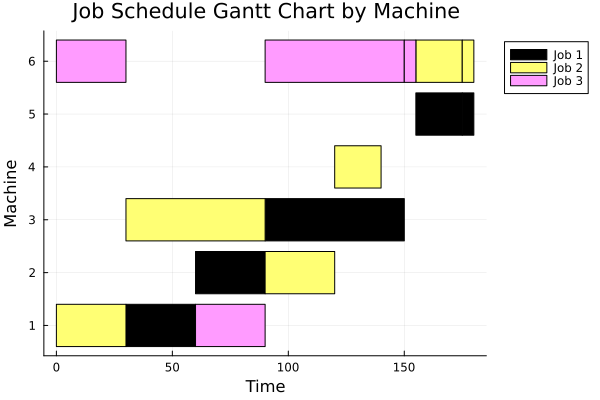

In [70]:
using Plots

# Function to plot Gantt chart with job legends
function plot_gantt_chart_with_job_legends(h_result, TX_result, x_result, nk, MM, num_jobs)
    end_times = Dict()
    for (j, k) in keys(TX_result)
        end_times[(j, k)] = h_result[(j, k)] + TX_result[(j, k)]
    end
    
    gantt_chart = plot(title="Job Schedule Gantt Chart by Machine", legend=:outertopright)

    # Generate a color for each job
    job_colors = distinguishable_colors(num_jobs)

    # Dictionary to keep track of which jobs have been plotted (to avoid duplicate legend entries)
    plotted_jobs = Dict()
    
    # Plot each task
    for k in 1:MM
        machine_schedule = []
        # Gather the tasks for this machine
        for i in 1:II
            for l in 1:LL[i]
                for j in 1:nk[k]
                    if get(x_result, (i, l, j, k), 0) > 0.1
                        push!(machine_schedule, (h_result[(j, k)], h_result[(j, k)] + TX_result[(j, k)], i))
                        break
                    end
                end
            end
        end
        for (start, finish, job_id) in machine_schedule
            color = job_colors[job_id]
            label = haskey(plotted_jobs, job_id) ? "" : "Job $job_id"  # Only label the first task of each job
            plotted_jobs[job_id] = true
            # plot!([start, finish], [k, k], bar=(150, color), label=label)
            shape = Shape([start, start, finish, finish], 
                      [k - 0.4, k + 0.4, k + 0.4, k - 0.4])
            plot!(shape, color=color, label=label)
        end
    end

    xlabel!("Time")
    ylabel!("Machine")
    return gantt_chart
end

# Assuming the model has been optimized and we have the results
# Calculate the end times for the tasks and populate h_result and TX_result accordingly

# Now let's create and display the Gantt chart with job legends
gantt_chart_with_job_legends = plot_gantt_chart_with_job_legends(h_result, TX_result, x_result, nk, MM, II)
display(gantt_chart_with_job_legends)

In [59]:
for (key, v) in x_result # i l j k
    if key[1] == 3 && key[4] == 6 && v > 0
        println(key, v)
    end
end

(3, 2, 2, 6)1.0
(3, 4, 6, 6)1.0
(3, 3, 4, 6)1.0


In [60]:
TX_result[(2, 6)]  # j k

30.0